# Trabalho de Redes Neurais

### 8. Valendo-se da base de dados reais referente ao Volume de Vendas de Passagens (VVP) de uma companhia aérea norte-americana que se encontra no arquivo vvp.xlsx, pede-se: 

#### 1) Desenvolver um previsor neural que receba como entradas os VVPs registrados nos instantes k-1 e k-12 (i.e. VVP(k-1) e VVP(k-12)) e que disponibilize na saída o VVP no instante corrente k (i.e. VVP(k)). O previsor deverá realizar previsões recursivas de 1 a 12 passos à frente (i.e., de um a doze meses à frente); 

In [12]:
#!pip install darts

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from darts import TimeSeries
from darts.models import RegressionModel

In [8]:
df = pd.read_excel('vvp.xlsx')

# Transpondo os dados da planilha, renomeando as colunas das variáveis de interesse, tratando tipo das colunas
df = (
    df[:1]
    .drop(columns=['Unnamed: 0','Unnamed: 1','Meses'],axis=1)
    .T
    .reset_index()
    .rename(columns={'index':'Meses', 0: 'VVP'})
    .astype({'VVP':np.float64})
    .assign(Meses = pd.date_range(start='1/1/1949', periods= 120, freq='M'))
    )

# Formatando as datas com apenas mês ano
df['Meses'] = df.Meses.dt.to_period('M')

O valor do MSE para a predição recursiva sem decomposição é de: 4509.179604567585


<Axes: xlabel='time'>

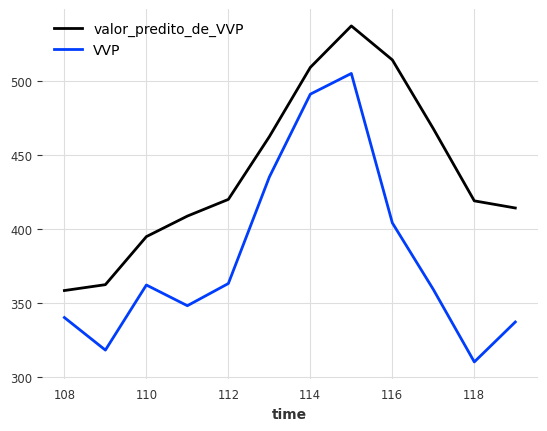

In [9]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_series(df.VVP)

# Set aside the last 12 months as a validation series
train, val = series[:-12], series[-12:]
model = RegressionModel(
    model = MLPRegressor(random_state=1, max_iter=500),
    lags = [-1, -12]
)

model.fit(series = train)

pred = model.predict(n = 12, series = train)

mse = mean_squared_error(pred.values(), val.values())

print(f'O valor do MSE para a predição recursiva sem decomposição é de: {mse}')

pred.plot(label= 'valor_predito_de_VVP')
val.plot(label= 'VVP')


#### 2) De posse da base de dados, remova a tendência linear presente na base de dados original. Desse modo, você conhecerá a série destendenciada e a tendência linear. Para a primeira série, desenvolva um previsor neural que receba como entradas os VVPs registrados nos instantes k-1 e k-12 (i.e. VVP(k-1) e VVP(k-12)) e que disponibilize na saída o VVP no instante corrente k (i.e. VVP(k)). O previsor deverá realizar previsões recursivas de 1 a 12 passos à frente (i.e., de um a doze meses à frente). Para a segunda (i.e., a tendência linear), preveja linearmente os próximos dozes pontos. Em seguida, some ponto a ponto as duas previsões e compare o desempenho dessa abordagem com a anterior apontando qual delas apresenta uma maior capacidade de generalização.

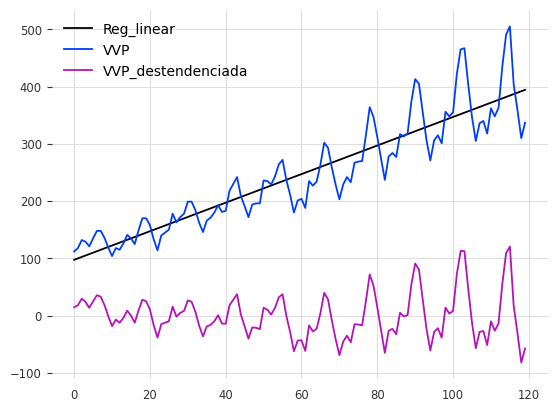

In [10]:
X = [i for i in range(0, len(df.VVP))]
X = np.reshape(X, (len(X), 1))
y = df.VVP
reg = LinearRegression()
reg.fit(X,y)
trend = reg.predict(X)

plt.plot(trend, label = 'Reg_linear')
plt.plot(y, label = 'VVP')

df['VVP_destendenciada'] = df.VVP - trend
plt.plot(df.VVP_destendenciada, label= 'VVP_destendenciada')

plt.legend()


O valor do MSE para a predição recursiva decomposta é de: 798.675206954702


/home/th/miniconda3/envs/machine_learning/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


<Axes: xlabel='time'>

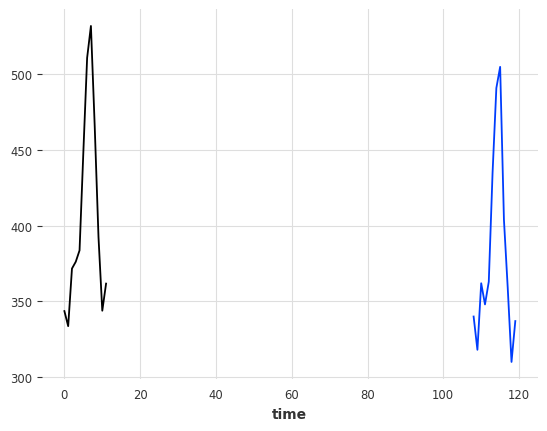

In [11]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_series(df.VVP_destendenciada)

# Set aside the last 12 months as a validation series
train = series[:-12]
val = df.VVP [-12:]

model = RegressionModel(
    model = MLPRegressor(random_state=1, max_iter=500),
    lags = [-1, -12]
)

model.fit(series = train)

pred = model.predict(n = 12, series = train)

pred_plus_trend = np.array([i[0] for i in pred.values()]) + trend[-12:]

mse = mean_squared_error(pred_plus_trend, val)

print(f'O valor do MSE para a predição recursiva decomposta é de: {mse}')

plt.plot(pred_plus_trend)
val.plot(label= 'VVP')